In [1]:
import numpy as np
import gensim
import string
import pandas as pd

from keras.callbacks import LambdaCallback
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file

C:\Users\rujjn\Anaconda3\envs\capstone2\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\rujjn\Anaconda3\envs\capstone2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [134]:
docs = pd.read_pickle('training_set.pkl')


# for clarity, rename numbered essay topics to one-word topic summary 

topic_dict = {'topic':{1: 'computers', 
                       2: 'censorship', 
                       3: 'cyclist', 
                       4: 'hibiscus', 
                       5: 'mood', 
                       6: 'dirigibles', 
                       7: 'patience', 
                       8: 'laughter'}}

docs.replace(topic_dict, inplace=True)

t12 = docs[['essay_id', 'topic', 'essay', 'target_score', 'tokens']]

t12.to_csv('t12.csv')

docs.head()

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,...,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6,char_len,word_count,tokens,lemma,pos
0,1,computers,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1875,351,"[Dear, local, newspaper, ,, I, think, effects,...","[dear, local, newspaper, ,, -PRON-, think, eff...","[ADJ, ADJ, NOUN, PUNCT, PRON, VERB, NOUN, NOUN..."
1,2,computers,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2288,424,"[Dear, @CAPS1, @CAPS2, ,, I, believe, that, us...","[dear, @caps1, @caps2, ,, -PRON-, believe, tha...","[ADJ, PROPN, PUNCT, PUNCT, PRON, VERB, ADP, VE..."
2,3,computers,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1541,284,"[Dear, ,, @CAPS1, @CAPS2, @CAPS3, More, and, m...","[dear, ,, @caps1, @caps2, @caps3, more, and, m...","[ADJ, PUNCT, PROPN, PUNCT, PROPN, ADJ, CCONJ, ..."
3,4,computers,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3165,531,"[Dear, Local, Newspaper, ,, @CAPS1, I, have, f...","[dear, local, newspaper, ,, @caps1, -PRON-, ha...","[ADJ, PROPN, PROPN, PUNCT, PROPN, PRON, VERB, ..."
4,5,computers,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2569,474,"[Dear, @LOCATION1, ,, I, know, having, compute...","[dear, @location1, ,, -PRON-, know, have, comp...","[ADJ, ADP, PUNCT, PRON, VERB, VERB, NOUN, VERB..."


In [19]:
print('\nFetching the text...')
url = 'https://raw.githubusercontent.com/maxim5/stanford-tensorflow-tutorials/master/data/arxiv_abstracts.txt'
path = get_file('arxiv_abstracts.txt', origin=url)

print('\nPreparing the sentences...')
max_sentence_len = 40
with open(path) as file_:
  docs = file_.readlines()
sentences = [[word for word in doc.lower().translate(string.punctuation).split()[:max_sentence_len]] for doc in docs]
print('Num sentences:', len(sentences))


Fetching the text...

Preparing the sentences...
Num sentences: 7200


In [3]:
# load ascii text and covert to lowercase
essays = docs[((docs.topic == 'computers') &
            (docs.target_score > 6)) |
            ((docs.topic == 'censorship') & 
            (docs.target_score > 2))]\
            ['tokens']

In [4]:
max_sentence_len = 40
# sentences = [[word for word in doc.lower().translate(string.punctuation).split()[:max_sentence_len]] for doc in essays]
sentences = [[word.lower() for word in doc[:max_sentence_len]] for doc in essays]
print('Num sentences:', len(sentences))

Num sentences: 3251


In [6]:
print('\nTraining word2vec...')
word_model = gensim.models.Word2Vec(sentences, size=100, min_count=1, window=5, iter=100)
pretrained_weights = word_model.wv.vectors
vocab_size, emdedding_size = pretrained_weights.shape
print('Result embedding shape:', pretrained_weights.shape)
print('Checking similar words:')
for word in ['computer', 'library', 'book', 'learn']:
  most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in word_model.wv.most_similar(word)[:8])
  print('  %s -> %s' % (word, most_similar))

def word2idx(word):
  return word_model.wv.vocab[word].index
def idx2word(idx):
  return word_model.wv.index2word[idx]

print('\nPreparing the data for LSTM...')
train_x = np.zeros([len(sentences), max_sentence_len], dtype=np.int32)
train_y = np.zeros([len(sentences)], dtype=np.int32)
for i, sentence in enumerate(sentences):
  for t, word in enumerate(sentence[:-1]):
    train_x[i, t] = word2idx(word)
  train_y[i] = word2idx(sentence[-1])
print('train_x shape:', train_x.shape)
print('train_y shape:', train_y.shape)


Training word2vec...
Result embedding shape: (5065, 100)
Checking similar words:
  computer -> computers (0.69), internet (0.40), infront (0.33), day (0.33), side (0.33), thing (0.33), effect (0.32), technology (0.32)
  library -> libraries (0.64), libary (0.59), book (0.39), walk (0.37), shelve (0.37), librarie (0.37), parent (0.37), libraies (0.35)
  book -> movie (0.52), material (0.49), books (0.47), magazine (0.46), place (0.42), somthing (0.42), something (0.42), song (0.41)
  learn -> talk (0.57), connect (0.52), communicate (0.49), learning (0.44), explore (0.43), teach (0.43), give (0.42), informs (0.41)

Preparing the data for LSTM...
train_x shape: (3251, 40)
train_y shape: (3251,)


In [7]:
print('\nTraining LSTM...')
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[pretrained_weights]))
model.add(LSTM(units=emdedding_size))
model.add(Dense(units=vocab_size))
model.add(Activation('softmax'))
optimizer = RMSprop(lr=0.01)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')


Training LSTM...


In [8]:
def sample(preds, temperature=1.0):
  if temperature <= 0:
    return np.argmax(preds)
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds) / temperature
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  probas = np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

#   choice = np.random.choice(len(preds), p=preds) 
#   return choice

In [9]:
def generate_next(text, num_generated=5):
  word_idxs = [word2idx(word) for word in text.lower().split()]
  for i in range(num_generated):
    prediction = model.predict(x=np.array(word_idxs))
    idx = sample(prediction[-1], temperature=0.7)
    word_idxs.append(idx)
  return ' '.join(idx2word(idx) for idx in word_idxs)

def on_epoch_end(epoch, _):
  print('\nGenerating text after epoch: %d' % epoch)
  texts = [
    'dear local newspaper every library should have these books',
    'books in library',
  ]
  for text in texts:
    gen_text = generate_next(text)
    print('%s... -> %s' % (text, gen_text))

In [76]:
model.fit(train_x, train_y,
          batch_size=128,
          epochs=40,
          callbacks=[LambdaCallback(on_epoch_end=on_epoch_end)])

Epoch 1/40
3251/3251 [==============================] - 3s 997us/step - loss: 4.7738

Generating text after epoch: 0
dear local newspaper every library should have these books... -> dear local newspaper every library should have these books neccessary hiding ur recorders mistake
books in library... -> books in library confirmed usage newapaper cell our
a computer... -> a computer misunderstanding exotic shelf- nessessarilly borught
a... -> a did like removed outspoken held
Epoch 2/40
3251/3251 [==============================] - 3s 990us/step - loss: 4.1838

Generating text after epoch: 1
dear local newspaper every library should have these books... -> dear local newspaper every library should have these books direction warm exclusive distribution kill
books in library... -> books in library deffinately atical easy cellular solitude
a computer... -> a computer judgement quality priorities shining toomany
a... -> a good shut @month1 package countries
Epoch 3/40
3251/3251 [===============

3251/3251 [==============================] - 4s 1ms/step - loss: 0.0251

Generating text after epoch: 18
dear local newspaper every library should have these books... -> dear local newspaper every library should have these books interacting tecnology weight young even
books in library... -> books in library available busy argue understand coolest
a computer... -> a computer offends word worried impact bad
a... -> a online then well and should
Epoch 20/40
3251/3251 [==============================] - 4s 1ms/step - loss: 0.0270

Generating text after epoch: 19
dear local newspaper every library should have these books... -> dear local newspaper every library should have these books strain on believe positive hundreds
books in library... -> books in library available 've item funding !
a computer... -> a computer have alot those in families
a... -> a such put could take leave
Epoch 21/40
3251/3251 [==============================] - 4s 1ms/step - loss: 0.0264A: 

Generating text after epoch

3251/3251 [==============================] - 3s 1ms/step - loss: 0.0042

Generating text after epoch: 36
dear local newspaper every library should have these books... -> dear local newspaper every library should have these books write was interesting offensive banned
books in library... -> books in library teenagers uses websites instant magazine
a computer... -> a computer @date1 ables it is in
a... -> a part since virtual going positions
Epoch 38/40
3251/3251 [==============================] - 3s 1ms/step - loss: 0.0406

Generating text after epoch: 37
dear local newspaper every library should have these books... -> dear local newspaper every library should have these books interacting come understand classic tell
books in library... -> books in library finds see sanction censoring censoring
a computer... -> a computer pros @caps5 able also piece
a... -> a part dangerous there hundreds draws
Epoch 39/40
3251/3251 [==============================] - 4s 1ms/step - loss: 0.0176

Generati

And now the same thing performed manually:

In [52]:
text = 'dear local newspaper'

In [80]:
num_generated = 8
word_idxs = [word2idx(word) for word in text.lower().split()]
for i in range(num_generated):
    prediction = model.predict(x=np.array(word_idxs))
    idx = sample(prediction[-1], temperature=0.7)
    word_idxs.append(idx)
print(' '.join(idx2word(idx) for idx in word_idxs))

dear local newspaper out question than the childrens ways angers with


The "sample" function run explicitly:

In [81]:
preds = prediction[-1]
preds

array([4.0528440e-04, 2.0602324e-04, 7.2131952e-05, ..., 4.6114925e-05,
       2.1005133e-05, 4.9224611e-05], dtype=float32)

36 ---> with


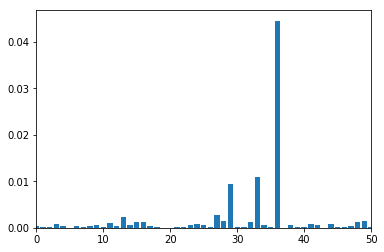

In [83]:
print(np.argmax(preds), '--->', idx2word(np.argmax(preds)))

import matplotlib.pyplot as plt
plt.bar(np.arange(len(preds)), preds)
plt.xlim(0,50)
plt.show()

In [84]:
preds_log = np.log(np.asarray(preds).astype('float64'))/0.7
preds_exp = np.exp(preds_log)
print(np.argmax(preds_exp))

36


In [85]:
preds_normalized = preds_exp/np.sum(preds_exp)
np.argmax(preds_normalized)

36

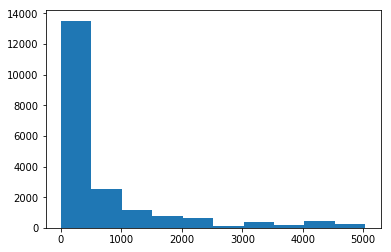

In [86]:
a = []
for i in range(20000):
    preds_random = np.random.multinomial(1, preds_normalized, 1)
    a.append(np.argmax(preds_random))
#     preds_random = np.random.choice(len(preds_normalized), p=preds_normalized)
#     a.append(preds_random)

plt.hist(a)
plt.show()

Alternative prediction:

In [130]:
def sample_prediction(prediction):
    rnd_idx = np.random.choice(len(prediction), p=prediction)
    return rnd_idx

text_output = ''
for i in range(8):
    text_output += idx2word(sample_prediction(preds)) + ' '

print(text_output)

with prove usage shelves through without ask air 


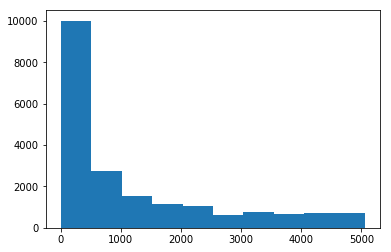

In [131]:
a = []
preds_normalized_2 = preds/np.sum(preds)

for i in range(20000):
#     preds_random = np.random.multinomial(1, preds_normalized, 1)
#     a.append(np.argmax(preds_random))
    preds_random = np.random.choice(len(preds_normalized_2), p=preds_normalized_2)
    a.append(preds_random)

plt.hist(a)
plt.show()

alternative #2

In [ ]:
for i in range(8):
x = numpy.reshape(pattern, (1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x, verbose=0)
    index = numpy.argmax(prediction)
    result = int_to_char[index]
    seq_in = [int_to_char[value] for value in pattern]
    sys.stdout.write(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print "\nDone."

 Gustavo Führ March 23, 2017 at 9:31 am #

Actually Jason,

I advanced my experiments and found some interesting things, I will probably do a Medium about it.

For the loop problem, as mentioned in http://karpathy.github.io/2015/05/21/rnn-effectiveness/, makes no sense to always use the argmax in the generation. Since the network output a list of probabilities is easy to randomically sample letter using this distribution:

def sample_prediction(char_map, prediction):
rnd_idx = np.random.choice(len(prediction), p=prediction)
return char_map[rnd_idx]

That simple change made the network to avoid loops and be much more diverse. (Using
temperature as you mentioned will be even better)

In [ ]:
def sample_prediction(prediction):
    """Get rand index from preds based on its prob distribution.

    Params
    ——
    prediction (array (array)): array of length 1 containing array of probs that sums to 1

    Returns
    ——-
    rnd_idx (int): random index from prediction[0]

    Notes
    —–
    Helps to solve problem of repeated outputs.

    len(prediction) = 1
    len(prediction[0]) >> 1
    """
    X = prediction[0] # sum(X) is approx 1
    rnd_idx = np.random.choice(len(X), p=X)
return rnd_idx

for i in range(num_outputs):
x = np.reshape(pattern, (1, len(pattern), 1))
x = x / float(n_vocab)
prediction = model.predict(x, verbose=0)
#index = numpy.argmax(prediction)
# per Gustavo’s suggestion, we should not use argmax here
index = sample_prediction(prediction)
result = int_to_char[index]
#seq_in = [int_to_char[value] for value in pattern]
# not sure why seq_in was here
sys.stdout.write(result)
pattern.append(index)
pattern = pattern[1:len(pattern)]
print “\nDone.”